# AM 207 - Deep Ensembles: A Loss Landscape

### Circular Toy Dataset Experimentation Notebook

#### Project Team: Emre Erdem, Carter Nakamoto, Anita Mahinpei

In [75]:
import keras
#from keras.datasets import cifar10
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
#from keras.layers import Conv2D, MaxPooling2D
#from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pymc3 as pm
from sklearn.preprocessing import scale
from sklearn.datasets import make_moons, make_circles

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns 

import theano
import theano.tensor as T
from warnings import filterwarnings

In [76]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [77]:
%config InlineBackend.figure_format = 'retina'
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
floatX = theano.config.floatX
filterwarnings('ignore')
sns.set_style('white')

## Toy dataset creation

In [78]:
# Generate a toy dataset for classification
def generate_toy1(n_samples):
    class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), n_samples)
    class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), n_samples)
    x = np.vstack((class_0, class_1))
    y = np.array([0] * n_samples + [1] * n_samples)
    return x,y

X,Y = generate_toy1(1000)

# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

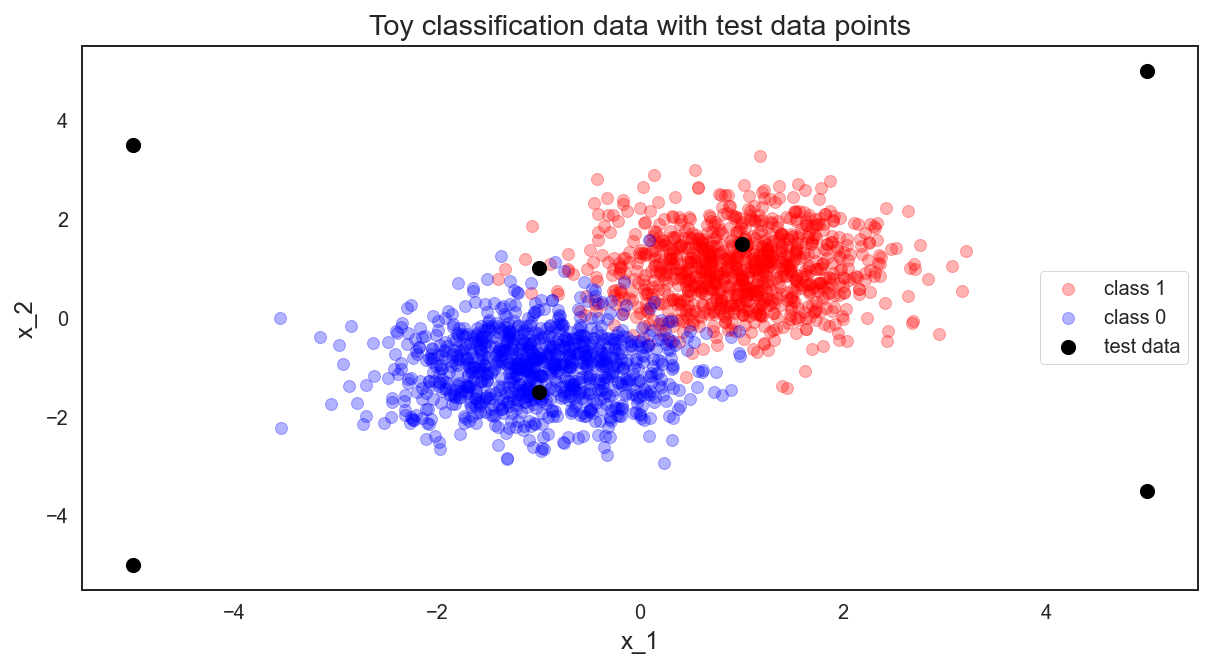

In [79]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('Toy classification data with test data points')
ax.legend(loc='best')
plt.show()

## Initial Neural Network Training

In [80]:
batch_size = 256
num_classes = 2
epochs = 100

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

x_train shape: (1000, 2)
x_test shape: (1000, 2)


In [82]:
# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)

In [83]:
Y_train.shape

(1000, 2)

In [84]:
input_shape = X_train.shape[1]
input_shape

2

In [85]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor, training=False)


def get_model(mc=False, p=0.5, act="relu"):
    inp = Input(shape=(input_shape,))
    x = Dense(128, activation=act)(inp)
    x = Dense(64, activation=act)(x)
    x = get_dropout(x, p=p, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [86]:
model = get_model(mc=False, act="relu")


In [87]:
model.summary()

Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_214 (Dense)            (None, 128)               384       
_________________________________________________________________
dense_215 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_72 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_216 (Dense)            (None, 2)                 130       
Total params: 8,770
Trainable params: 8,770
Non-trainable params: 0
_________________________________________________________________


In [88]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
h = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[es],
                    validation_data=(X_test, Y_test))

Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 1s 712us/step - loss: 0.6467 - accuracy: 0.6430 - val_loss: 0.5610 - val_accuracy: 0.8520
Epoch 2/100
1000/1000 [==============================] - 0s 24us/step - loss: 0.5222 - accuracy: 0.9300 - val_loss: 0.4444 - val_accuracy: 0.9710
Epoch 3/100
1000/1000 [==============================] - 0s 25us/step - loss: 0.4182 - accuracy: 0.9730 - val_loss: 0.3513 - val_accuracy: 0.9720
Epoch 4/100
1000/1000 [==============================] - 0s 23us/step - loss: 0.3369 - accuracy: 0.9770 - val_loss: 0.2795 - val_accuracy: 0.9730
Epoch 5/100
1000/1000 [==============================] - 0s 26us/step - loss: 0.2709 - accuracy: 0.9760 - val_loss: 0.2205 - val_accuracy: 0.9740
Epoch 6/100
1000/1000 [==============================] - 0s 25us/step - loss: 0.2163 - accuracy: 0.9770 - val_loss: 0.1739 - val_accuracy: 0.9730
Epoch 7/100
1000/1000 [==============================] - 0s 21us/step - los

In [89]:
weights = model.get_weights()
model.save_weights('initial_model_weights.h5')

In [90]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [91]:
pred2 = model.predict(grid_2d)[:,0].flatten()
pred = model.predict(X_test)[:,0].flatten() > 0.5

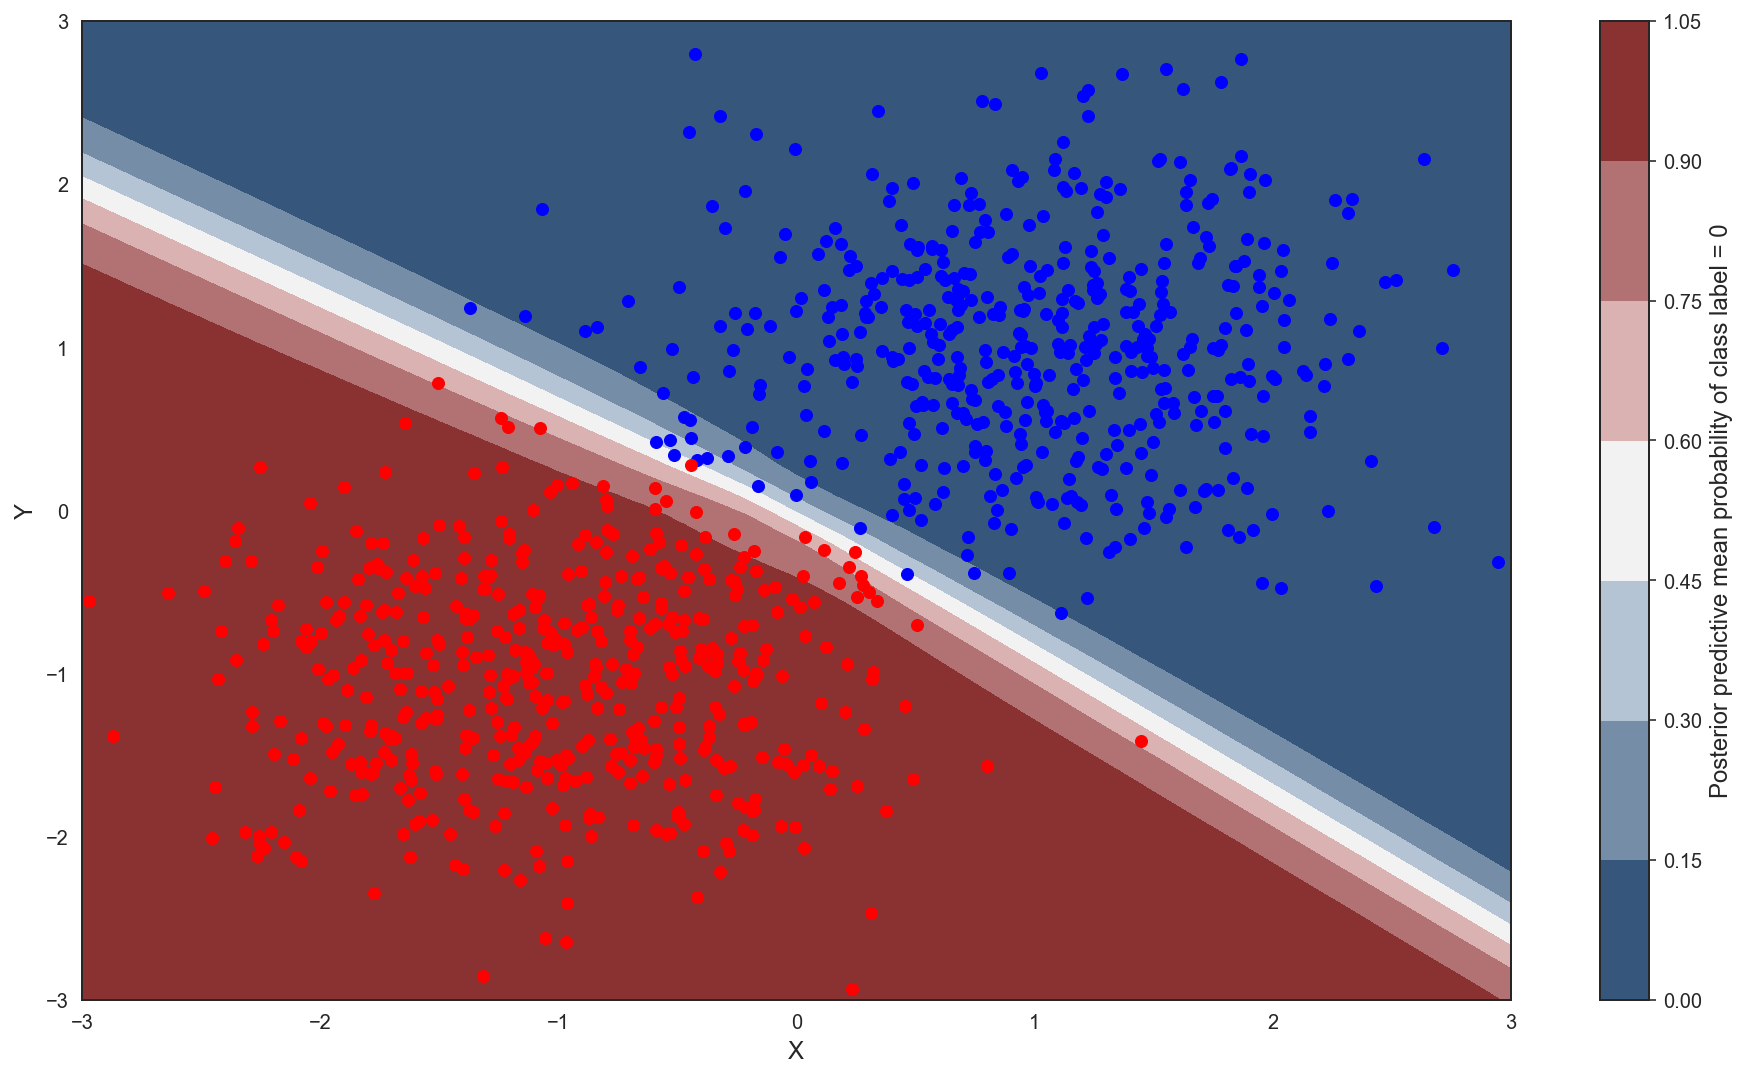

In [92]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], pred2.reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1], color='b')
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Prediction probabilities - (Test Set)")
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

## Deep Ensemble with Random Initialization

In [19]:
ensembles = 30
ens_test_probs = []
ens_ood_probs = []
ens_weights = []
grid_preds = []

for i in range(ensembles):
    #bootstrap_x, bootstrap_y = resample(X,Y)
    #bootstrap_y = keras.utils.to_categorical(bootstrap_y, num_classes)
    
    # Fit neural network model
    nn = model.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        callbacks=[es],
                    validation_data=(X_test, Y_test))
    
    weights = model.get_weights()
    #Get last Dense layer weights
    ens_weights.append(weights[4].T[1])
    
    # Accuracy of model
    score = model.evaluate(X_test, Y_test, verbose=0)
    #print('Test loss:', np.round(score[0],2))
    test_prob = model.predict(np.array(X_test))
    
    ens_test_probs.append(test_prob)
    print("Iteration: " + str(i+1) +' Test accuracy:'+ str(np.round(score[1],2)))
        
    #Predictions & uncertainty for test points
    ood_prob = model.predict(np.array(test_points))
    ens_ood_probs.append(ood_prob)

    pred2 = model.predict(grid_2d)[:,0].flatten()
    grid_preds.append(pred2)

Iteration: 1 Test accuracy:0.98
Iteration: 2 Test accuracy:0.98
Iteration: 3 Test accuracy:0.98
Iteration: 4 Test accuracy:0.98
Iteration: 5 Test accuracy:0.98
Iteration: 6 Test accuracy:0.98
Iteration: 7 Test accuracy:0.98
Iteration: 8 Test accuracy:0.98
Iteration: 9 Test accuracy:0.98
Iteration: 10 Test accuracy:0.98
Iteration: 11 Test accuracy:0.98
Iteration: 12 Test accuracy:0.98
Iteration: 13 Test accuracy:0.98
Iteration: 14 Test accuracy:0.98
Iteration: 15 Test accuracy:0.98
Iteration: 16 Test accuracy:0.98
Iteration: 17 Test accuracy:0.98
Iteration: 18 Test accuracy:0.98
Iteration: 19 Test accuracy:0.98
Iteration: 20 Test accuracy:0.98
Iteration: 21 Test accuracy:0.98
Iteration: 22 Test accuracy:0.98
Iteration: 23 Test accuracy:0.98
Iteration: 24 Test accuracy:0.98
Iteration: 25 Test accuracy:0.98
Iteration: 26 Test accuracy:0.98
Iteration: 27 Test accuracy:0.98
Iteration: 28 Test accuracy:0.98
Iteration: 29 Test accuracy:0.98
Iteration: 30 Test accuracy:0.98


In [20]:
ens_mean = np.mean(np.array(ens_test_probs),axis=0)
pred_test_labels = (ens_mean > 0.5).astype(np.int) 
score = accuracy_score(Y_test, pred_test_labels)
print("Ensemble prediction accuracy score for test data: ", score)

Ensemble prediction accuracy score for test data:  0.976


In [21]:
ens_variance = np.std(np.array(ens_ood_probs),axis=0)**2

for i in range(len(test_points)):
    print("Epistemic uncertainty for test point: " + str(test_points[i]) + " : " + str(np.round(ens_variance[i][0],3)))

Epistemic uncertainty for test point: (-5, -5) : 0.0
Epistemic uncertainty for test point: (-5, 3.5) : 0.0
Epistemic uncertainty for test point: (5, 5) : 0.0
Epistemic uncertainty for test point: (5, -3.5) : 0.028
Epistemic uncertainty for test point: (-1, 1) : 0.0
Epistemic uncertainty for test point: (-1, -1.5) : 0.0
Epistemic uncertainty for test point: (1, 1.5) : 0.0


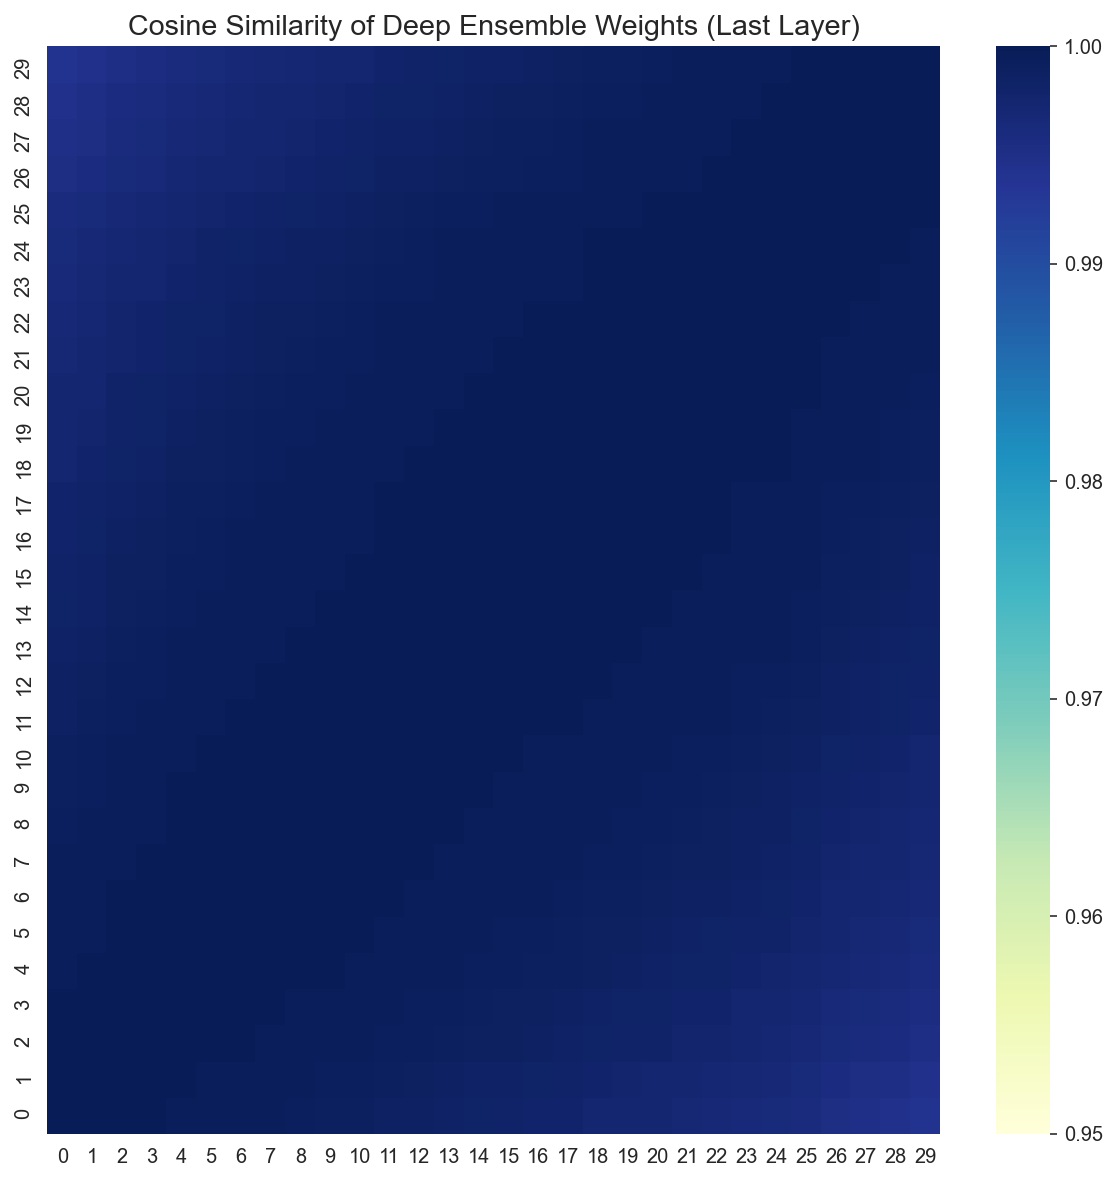

In [22]:
df = pd.DataFrame(np.array(ens_weights).T)

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(df.corr(),vmin=0.95, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("Cosine Similarity of Deep Ensemble Weights (Last Layer)")
ax.invert_yaxis()
plt.show()

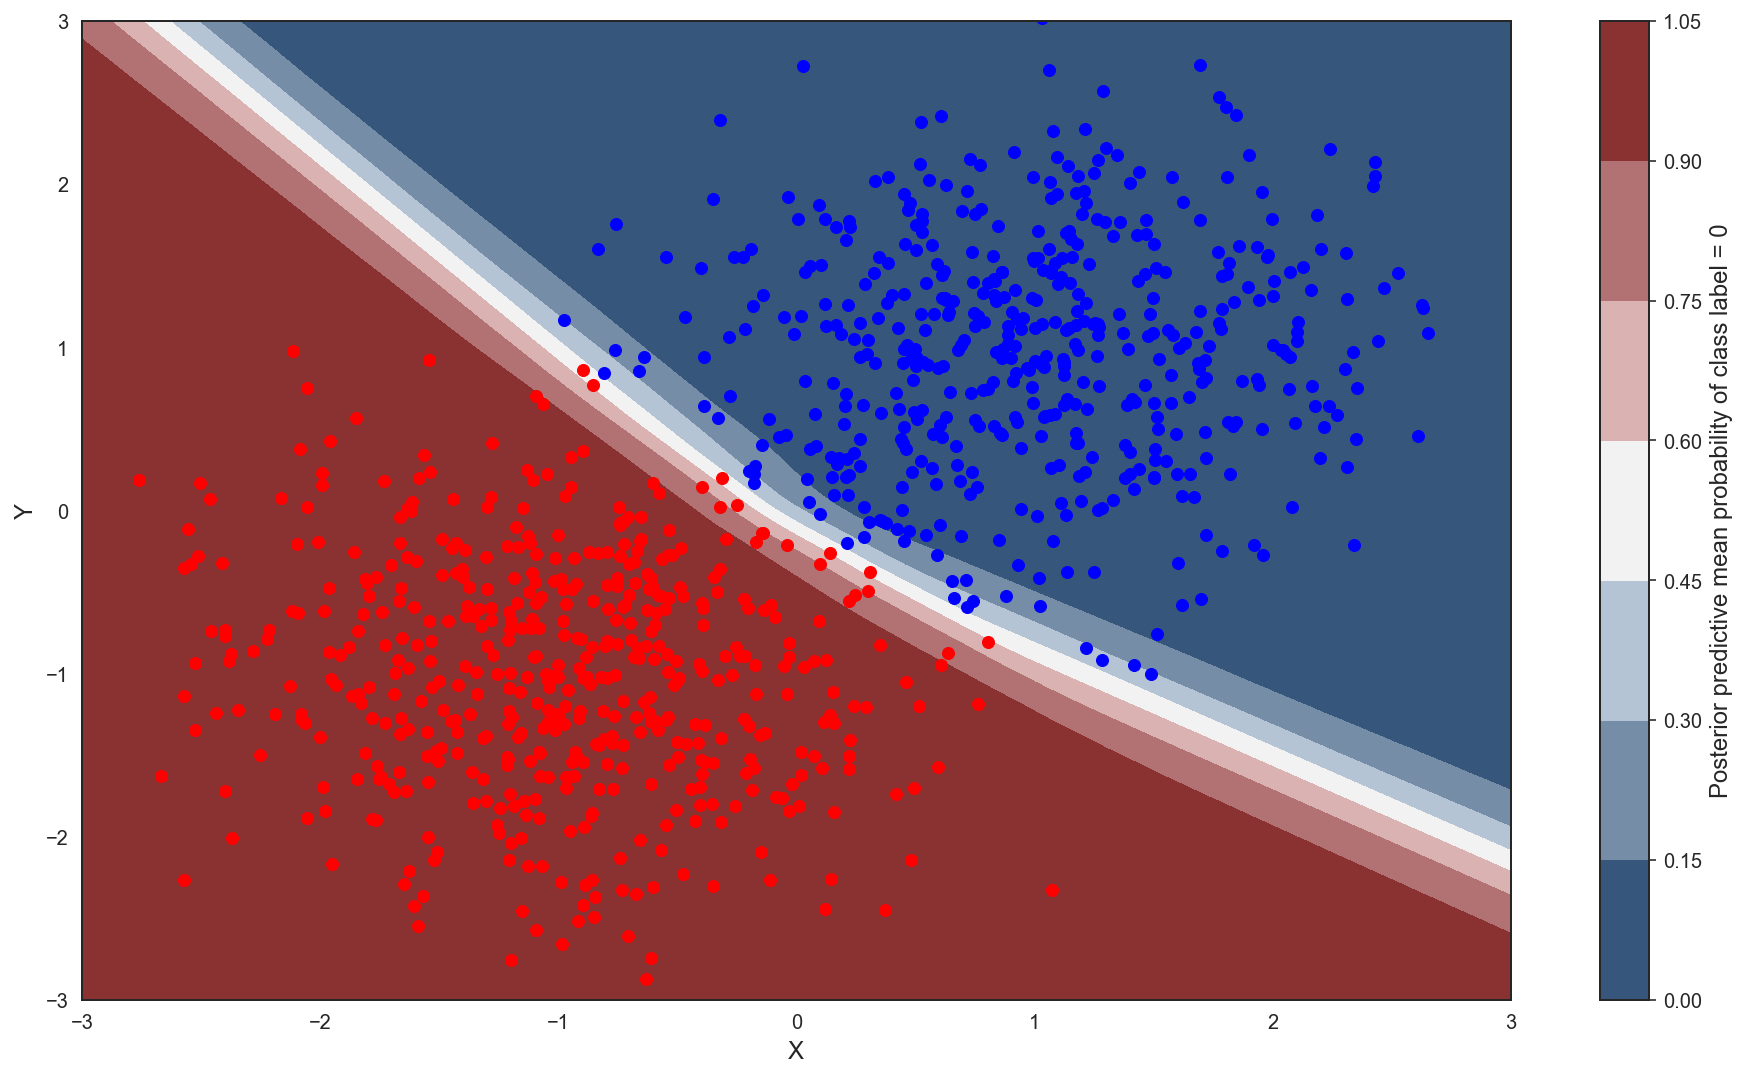

In [23]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.mean(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred_test_labels[:,0]==0, 0], X_test[pred_test_labels[:,0]==0, 1], color='b')
ax.scatter(X_test[pred_test_labels[:,0]==1, 0], X_test[pred_test_labels[:,0]==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Posterior predictive mean probabilities - (Test Set)")
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

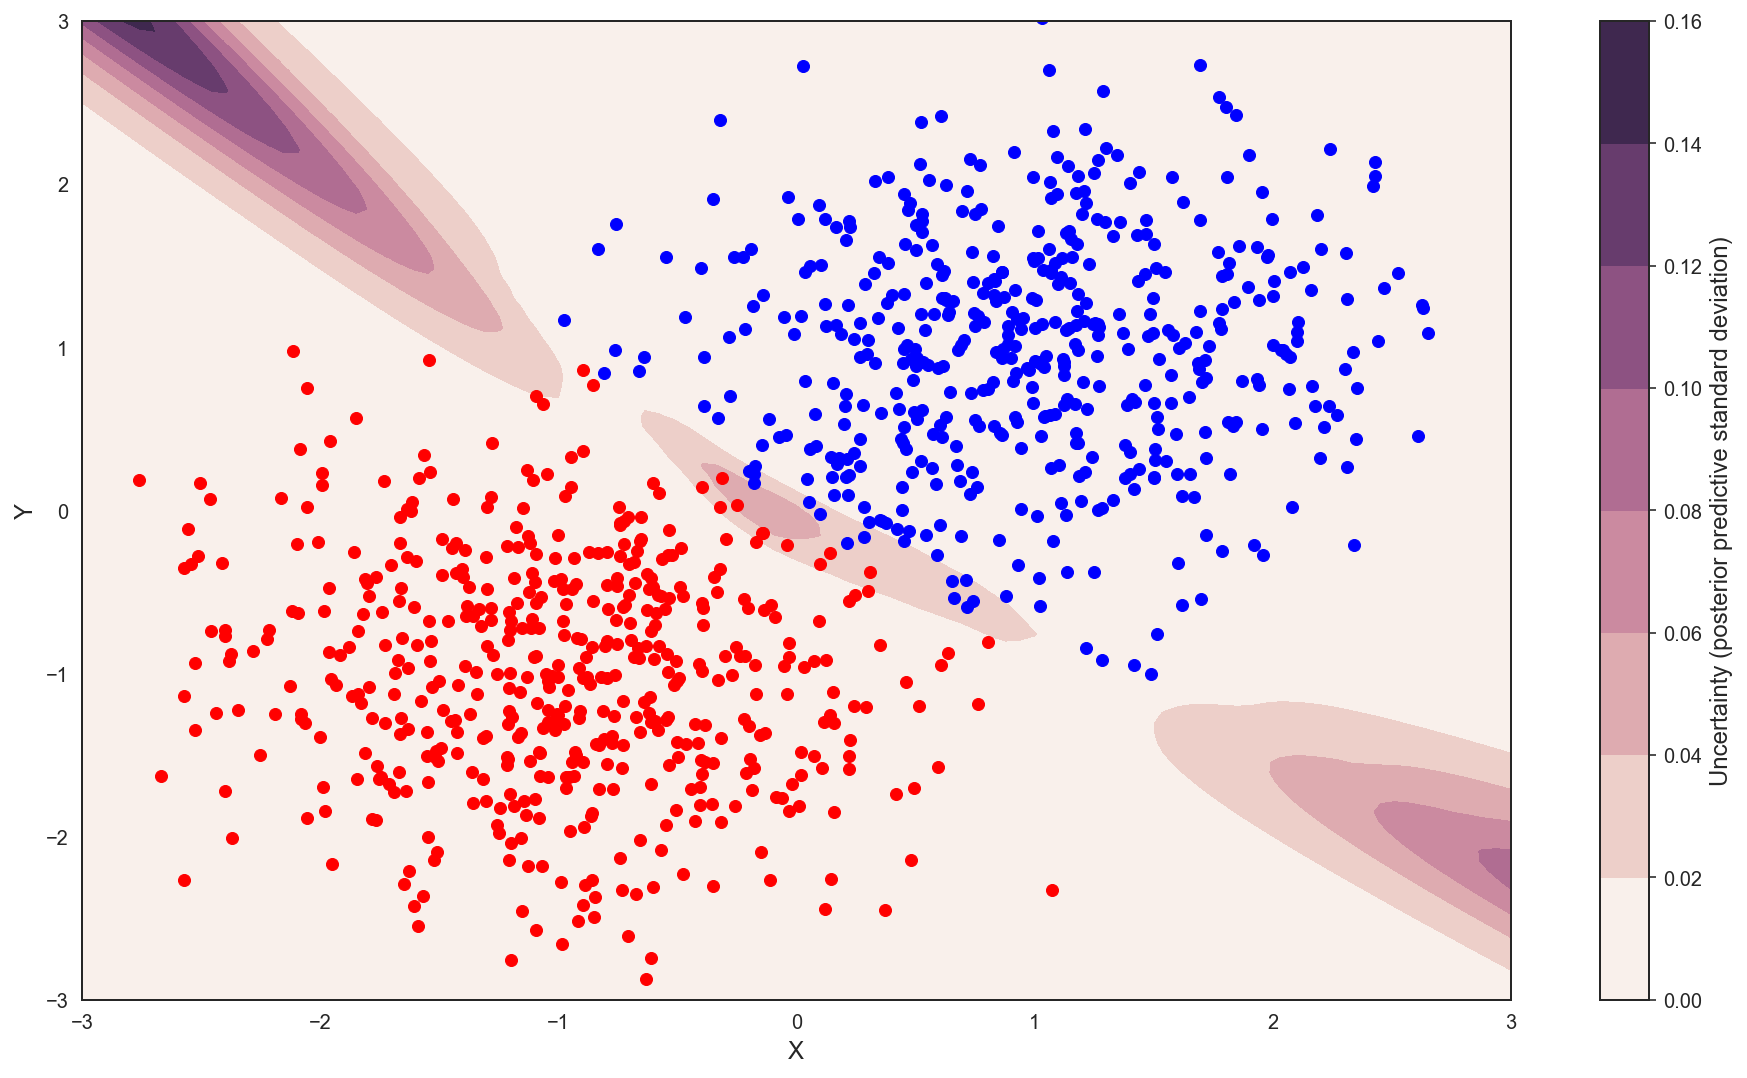

In [24]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.std(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred_test_labels[:,0]==0, 0], X_test[pred_test_labels[:,0]==0, 1], color='b')
ax.scatter(X_test[pred_test_labels[:,0]==1, 0], X_test[pred_test_labels[:,0]==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Epistemic Uncertainty Plot (Test Set)")
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## Bayesian Dropout Subsampling

In [25]:
bayes_iters = 30
dropout_post_predictions = []
dropout_ood_probs = []
drop_weights = []
grid_preds = []

for i in range(bayes_iters):
    #Generate random p value for Dropout ratio
    p_rand = np.random.random()
    
    drop_model = get_model(mc=True, p= p_rand, act="relu")
    
    #Initialize model with pre-trained weights
    drop_model.load_weights('initial_model_weights.h5')
    h_mc = drop_model.fit(Y_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        callbacks=[es],
                        validation_data=(X_test, Y_test))
    
    weights = drop_model.get_weights()
    #Get last Dense layer weights
    drop_weights.append(weights[4].T[1])
    
    # Accuracy of model
    score = drop_model.evaluate(X_test, Y_test, verbose=0)
    #print('Test loss:', np.round(score[0],2))
    print("Iteration: " + str(i+1) + " Random p: " + str(np.round(p_rand,2)) + ' Test accuracy: ', str(np.round(score[1],2)))
    
    #Posterior predictions
    y_pred = drop_model.predict(X_test)
    dropout_post_predictions.append(y_pred)
    
    #Predictions & uncertainty for test points
    ood_prob = drop_model.predict(np.array(test_points))
    dropout_ood_probs.append(ood_prob)
    
    pred2 = drop_model.predict(grid_2d)[:,0].flatten()
    grid_preds.append(pred2)

Iteration: 1 Random p: 0.67 Test accuracy:  0.94
Iteration: 2 Random p: 0.09 Test accuracy:  0.95
Iteration: 3 Random p: 0.11 Test accuracy:  0.95
Iteration: 4 Random p: 0.14 Test accuracy:  0.95
Iteration: 5 Random p: 0.77 Test accuracy:  0.93
Iteration: 6 Random p: 0.34 Test accuracy:  0.94
Iteration: 7 Random p: 0.55 Test accuracy:  0.95
Iteration: 8 Random p: 0.81 Test accuracy:  0.93
Iteration: 9 Random p: 0.43 Test accuracy:  0.94
Iteration: 10 Random p: 0.22 Test accuracy:  0.95
Iteration: 11 Random p: 0.93 Test accuracy:  0.85
Iteration: 12 Random p: 0.43 Test accuracy:  0.94
Iteration: 13 Random p: 0.35 Test accuracy:  0.94
Iteration: 14 Random p: 0.97 Test accuracy:  0.76
Iteration: 15 Random p: 0.95 Test accuracy:  0.8
Iteration: 16 Random p: 0.36 Test accuracy:  0.94
Iteration: 17 Random p: 0.71 Test accuracy:  0.94
Iteration: 18 Random p: 0.6 Test accuracy:  0.94
Iteration: 19 Random p: 0.94 Test accuracy:  0.82
Iteration: 20 Random p: 0.42 Test accuracy:  0.95
Iteration: 

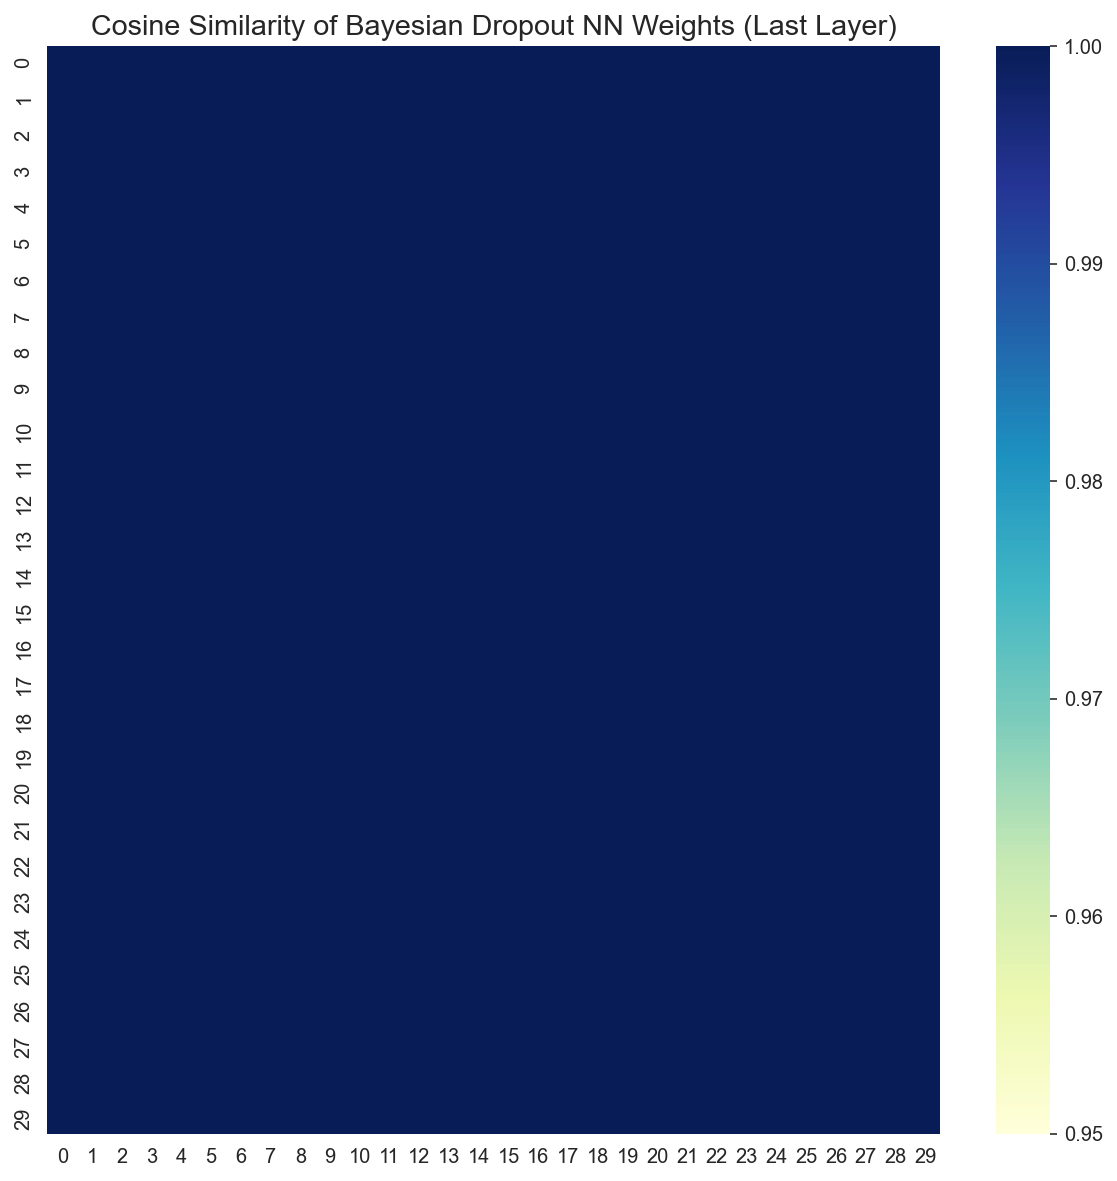

In [26]:
df = pd.DataFrame(np.array(drop_weights).T)

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(df.corr(),vmin=0.95, vmax=1, cmap="YlGnBu") 
#ax.invert_yaxis()
plt.title("Cosine Similarity of Bayesian Dropout NN Weights (Last Layer)")
plt.show()

In [27]:
dropout_posterior_mean_preds = np.mean(np.array(dropout_post_predictions),axis=0)
dropout_posterior_mean_preds.shape

(1000, 2)

In [28]:
dropout_pred_test_labels = (dropout_posterior_mean_preds > 0.5).astype(np.int) 
dropout_acc_score = accuracy_score(Y_test, dropout_pred_test_labels)
print("Bayesian Dropout posterior predictive mean accuracy score for test data: ", dropout_acc_score)

Bayesian Dropout posterior predictive mean accuracy score for test data:  0.947


In [29]:
drop_ood_variance = np.std(np.array(dropout_ood_probs),axis=0)**2

for i in range(len(test_points)):
    print("Epistemic uncertainty for test point: " + str(test_points[i]) + " : " + str(np.round(drop_ood_variance[i][0],3)))

Epistemic uncertainty for test point: (-5, -5) : 0.008
Epistemic uncertainty for test point: (-5, 3.5) : 0.05
Epistemic uncertainty for test point: (5, 5) : 0.008
Epistemic uncertainty for test point: (5, -3.5) : 0.001
Epistemic uncertainty for test point: (-1, 1) : 0.035
Epistemic uncertainty for test point: (-1, -1.5) : 0.015
Epistemic uncertainty for test point: (1, 1.5) : 0.018


In [30]:
dropout_pred_test_labels.shape

(1000, 2)

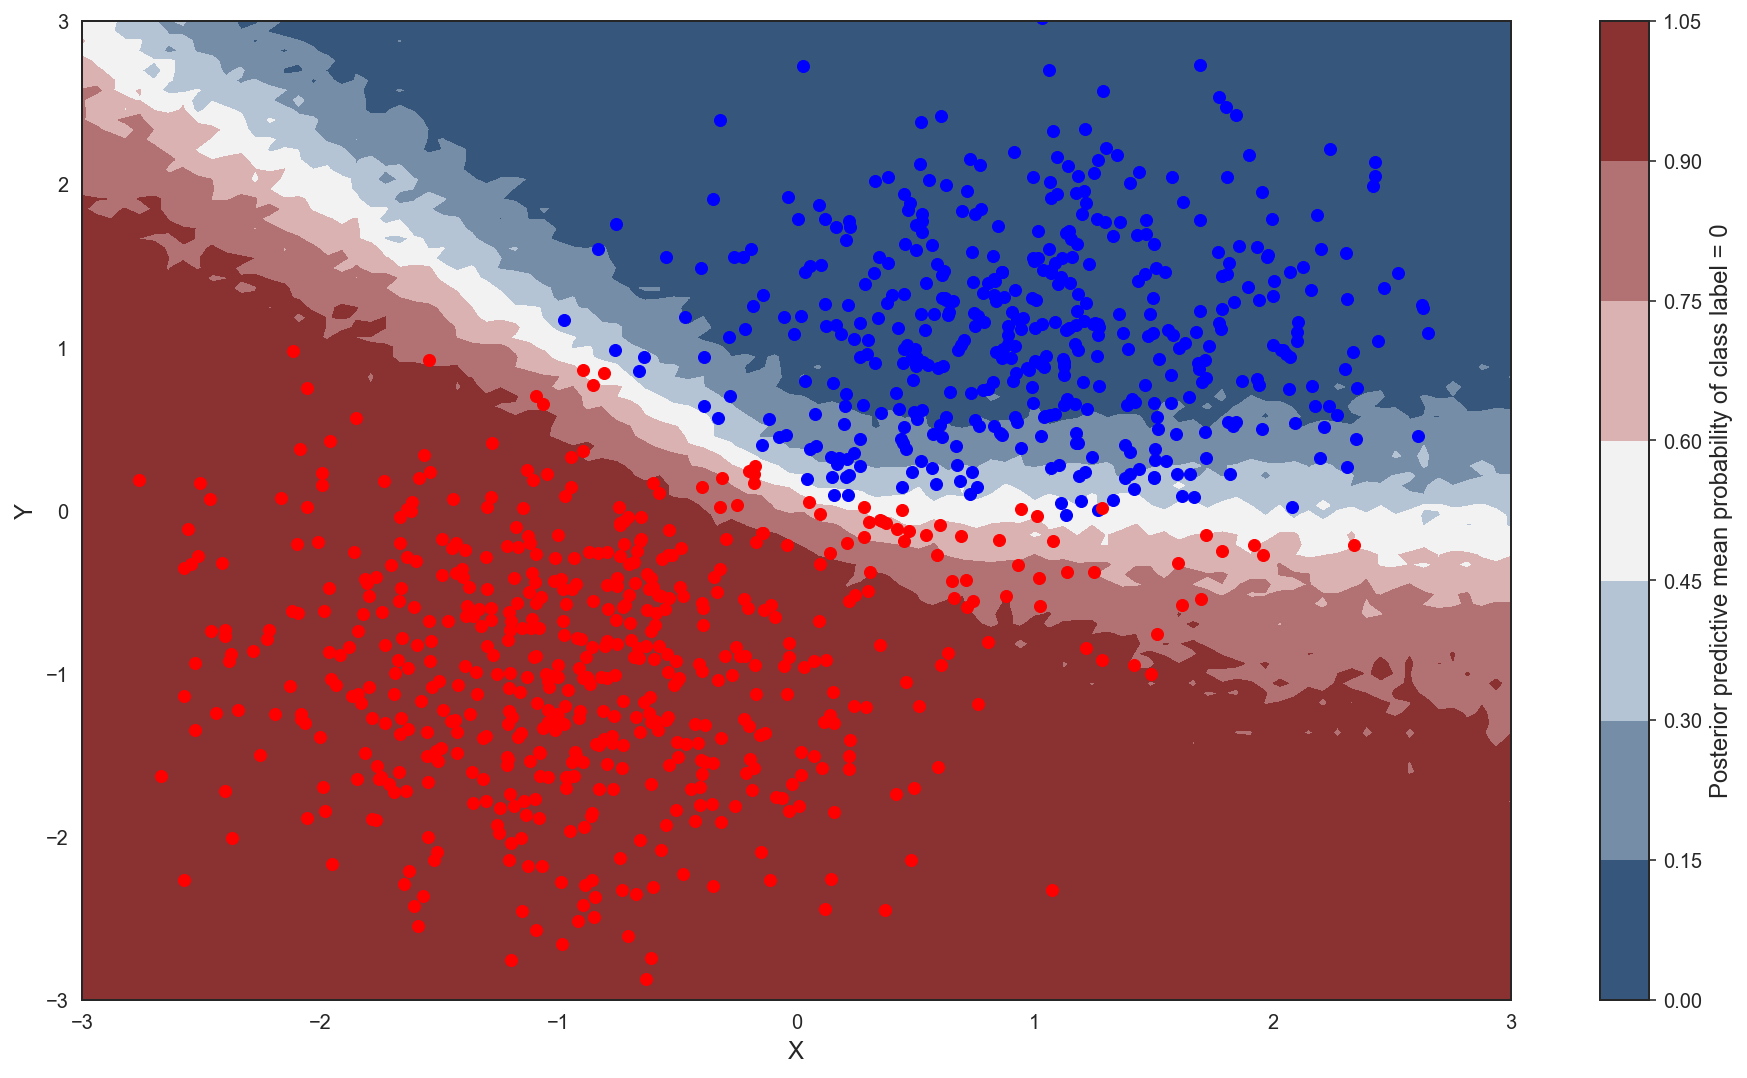

In [31]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.mean(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[dropout_pred_test_labels[:,0]==0, 0], X_test[dropout_pred_test_labels[:,0]==0, 1], color='b')
ax.scatter(X_test[dropout_pred_test_labels[:,0]==1, 0], X_test[dropout_pred_test_labels[:,0]==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Posterior predictive mean probabilities - (Test Set)")
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

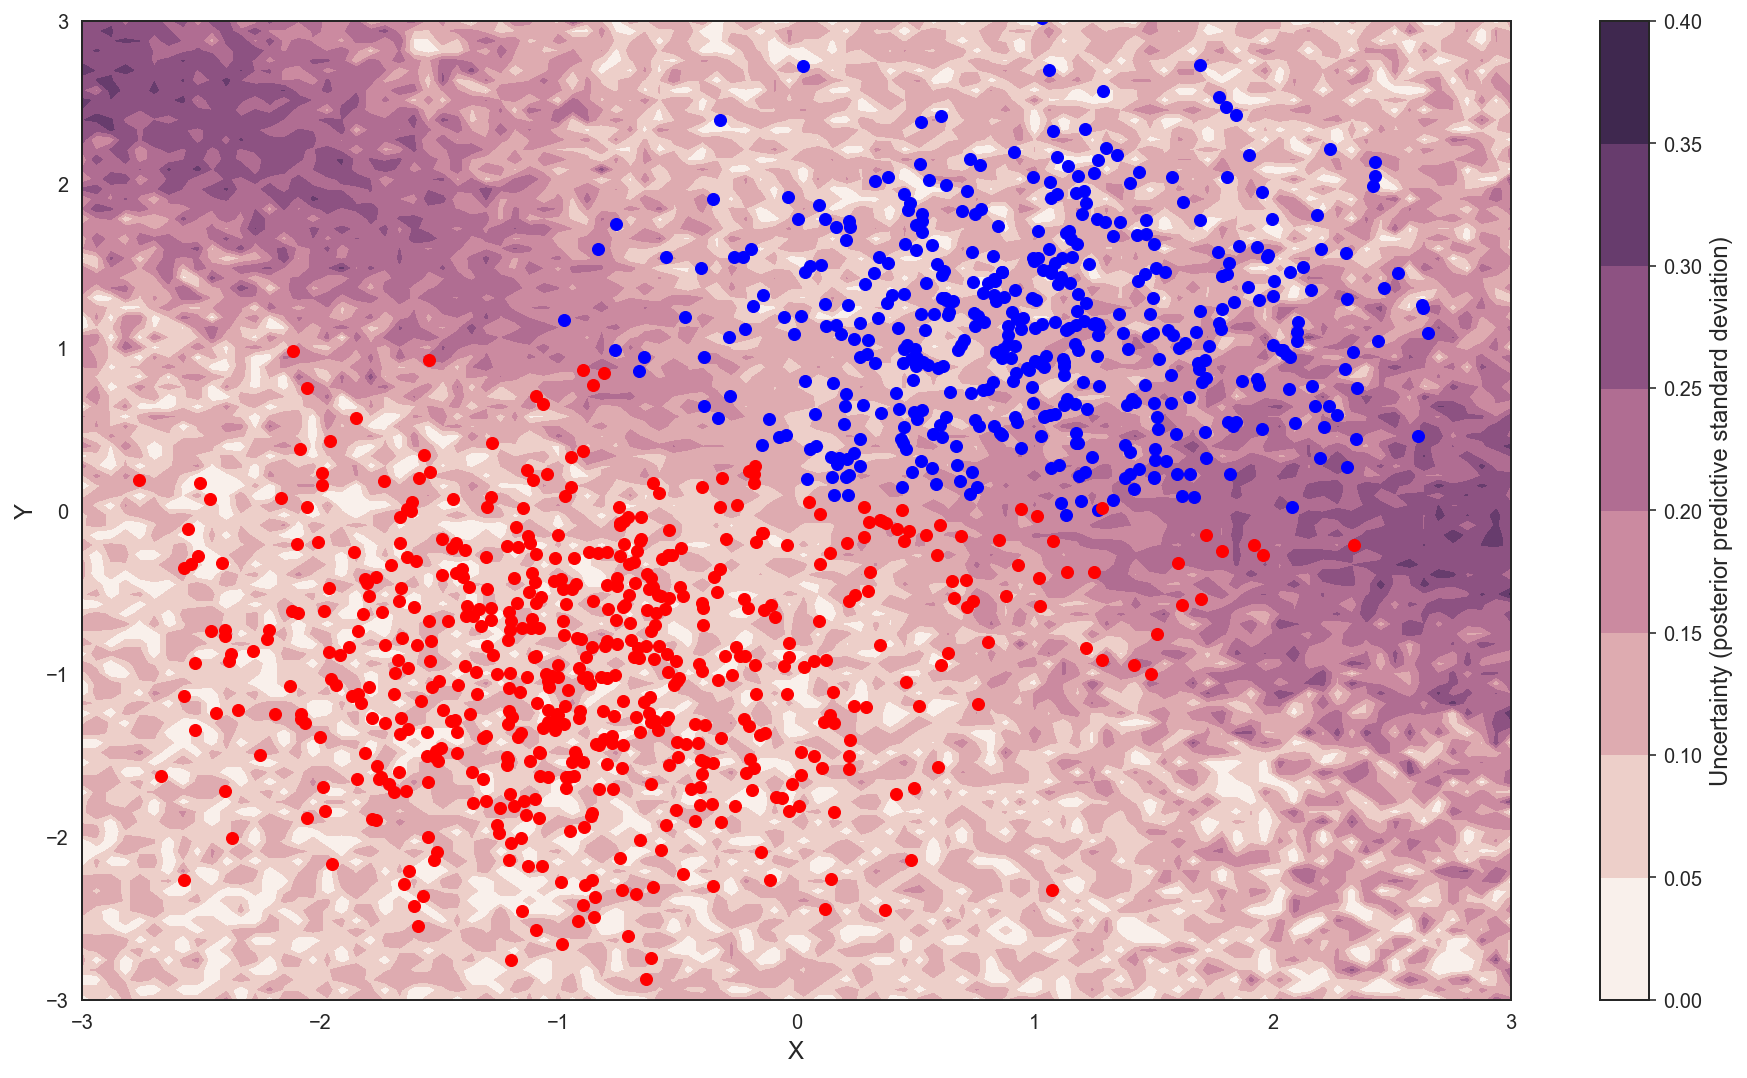

In [32]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.std(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[dropout_pred_test_labels[:,0]==0, 0], X_test[dropout_pred_test_labels[:,0]==0, 1], color='b')
ax.scatter(X_test[dropout_pred_test_labels[:,0]==1, 0], X_test[dropout_pred_test_labels[:,0]==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Epistemic Uncertainty Plot (Test Set)")
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## Random Subspace Sampling

In [93]:
models = []
random_weights= []
# iterate over different samples
for i in range(bayes_iters):
    # make a new NN with the same layout
    model2 = get_model(mc=False, act="relu")
    # add random vector to presaved model weights
    model.load_weights('initial_model_weights.h5')
    #Added scale to regularize randomness
    weights = [model.get_weights()[j] + np.random.normal(size = model.get_weights()[j].shape, scale=0.2) for j in range(len(model.get_weights()))]
    model2.set_weights(weights)
    #Get last Dense layer weights
    random_weights.append(weights[4].T[1])
    models.append(model2)

In [94]:
random_post_predictions = []
grid_preds = []

for model in models: 
    y_pred = model.predict(X_test)
    random_post_predictions.append(y_pred)
    pred2 = model.predict(grid_2d)[:,0].flatten()
    grid_preds.append(pred2)
    
random_posterior_mean_preds = np.mean(np.array(random_post_predictions),axis=0)
random_pred_test_labels = (random_posterior_mean_preds > 0.5).astype(np.int) 
random_acc_score = accuracy_score(Y_test, random_pred_test_labels)
print("Random subspace posterior predictive Test set mean accuracy score for test data: ", random_acc_score)

Random subspace posterior predictive Test set mean accuracy score for test data:  0.972


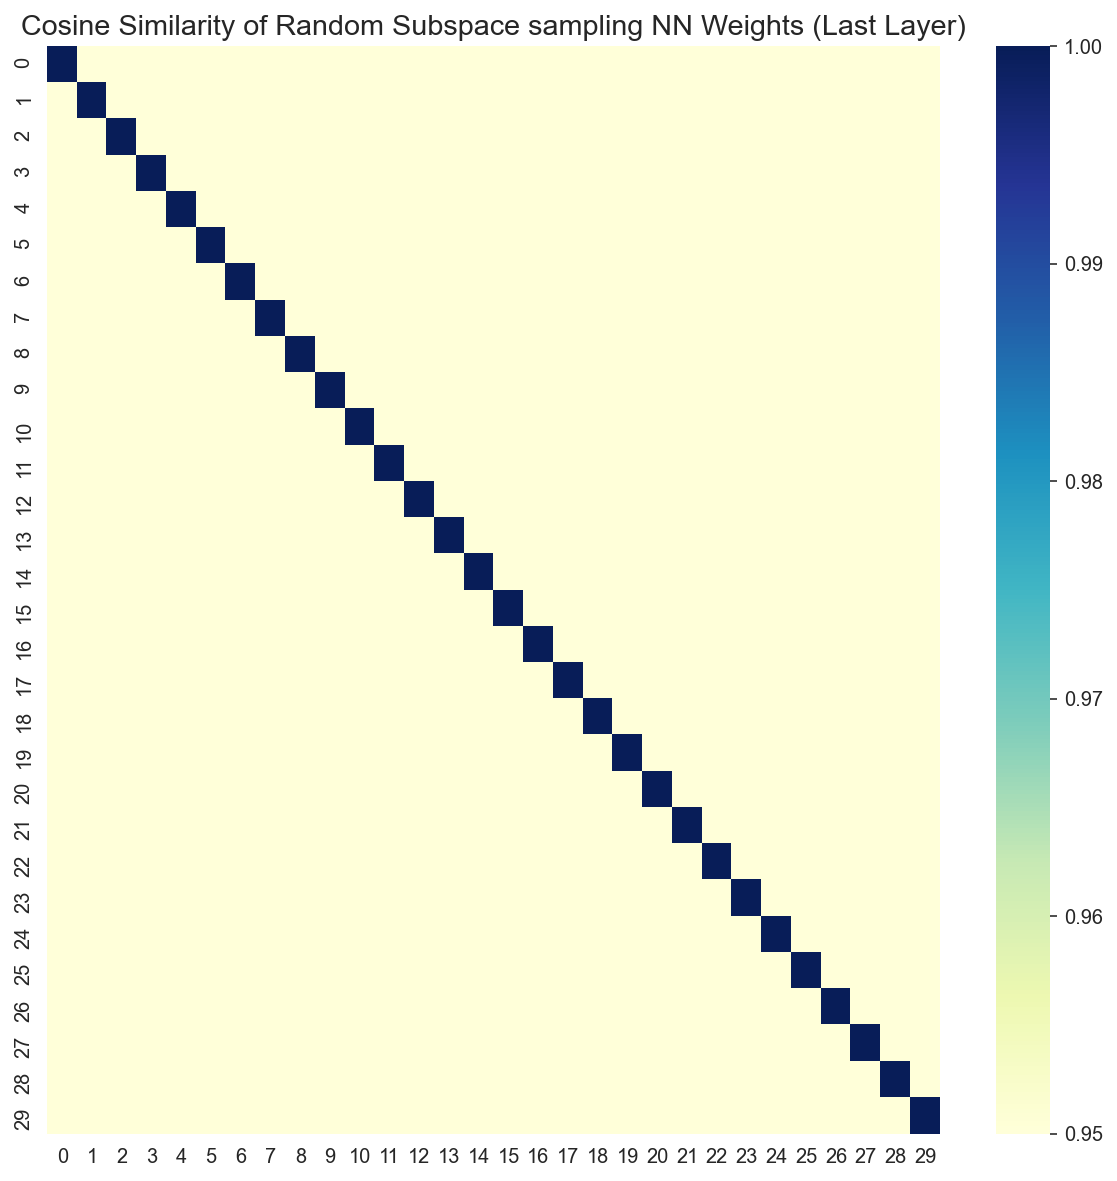

In [95]:
df = pd.DataFrame(np.array(random_weights).T)

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(df.corr(),vmin=0.95, vmax=1, cmap="YlGnBu") 
#ax.invert_yaxis()
plt.title("Cosine Similarity of Random Subspace sampling NN Weights (Last Layer)")
plt.show()

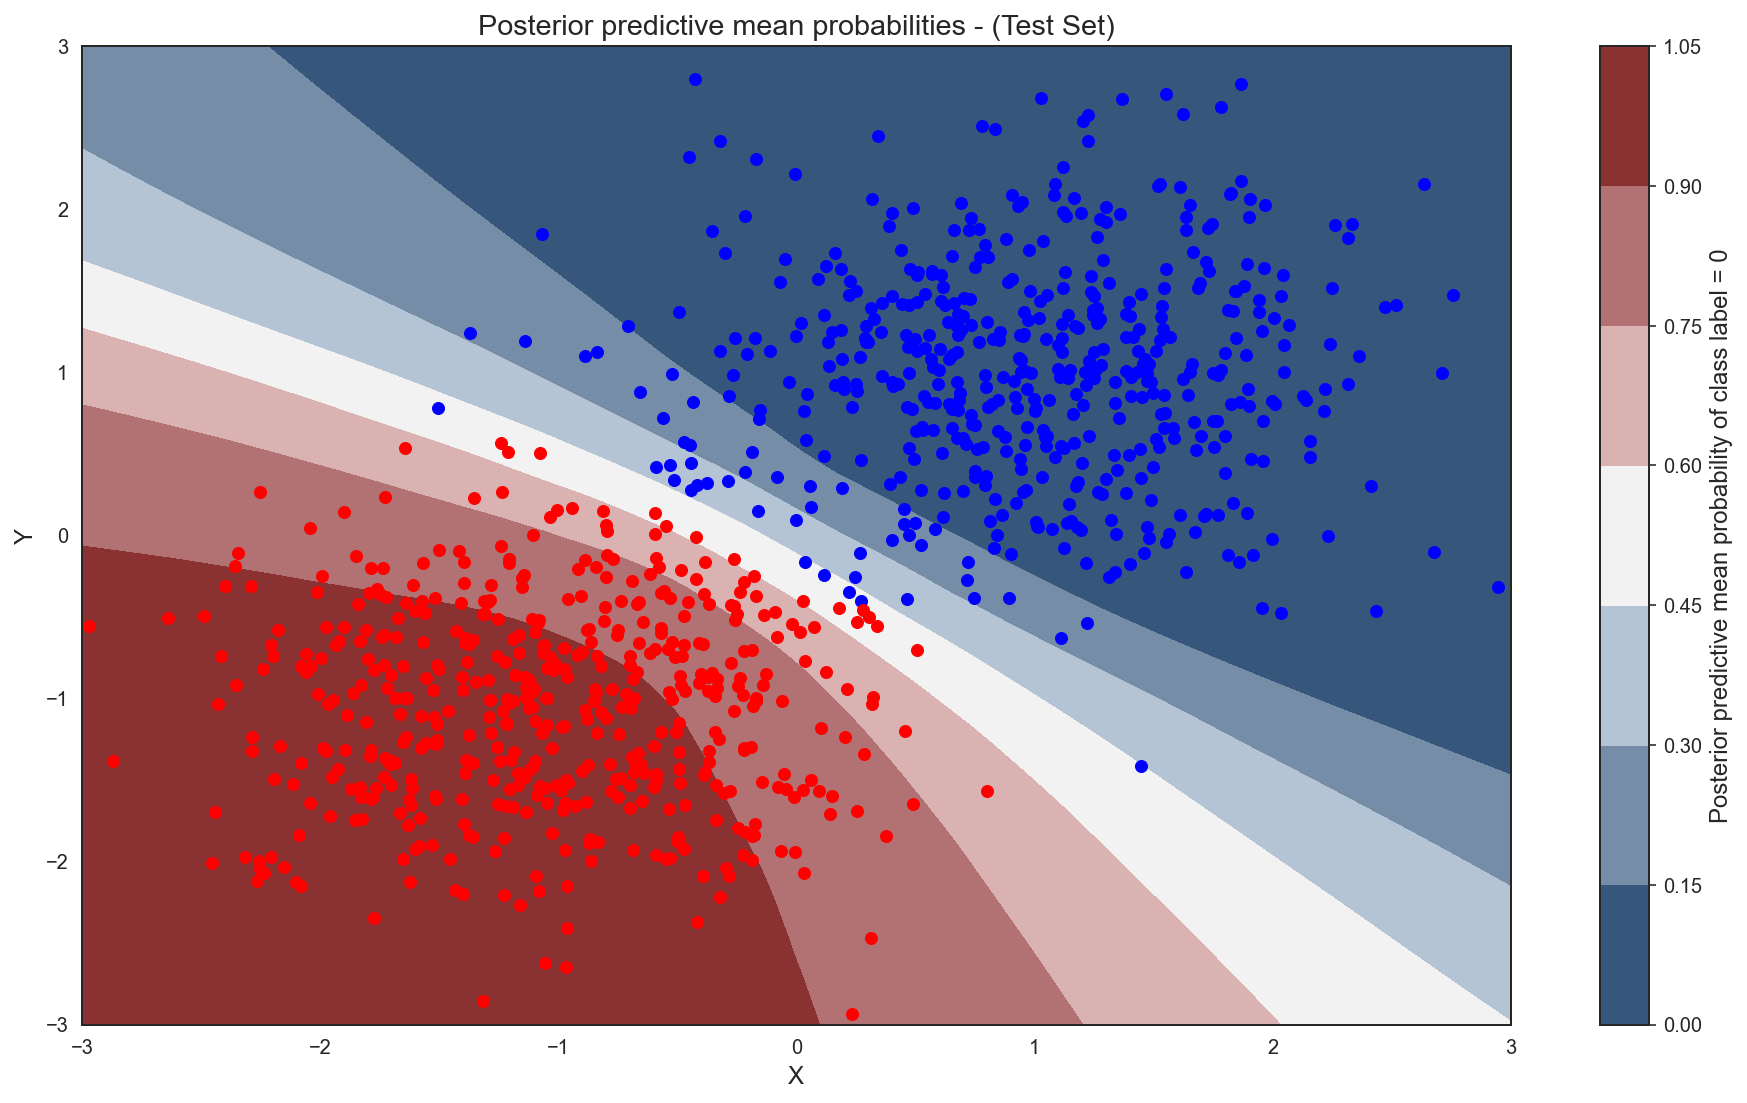

In [96]:
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.mean(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[random_pred_test_labels[:,0]==0, 0], X_test[random_pred_test_labels[:,0]==0, 1], color='b')
ax.scatter(X_test[random_pred_test_labels[:,0]==1, 0], X_test[random_pred_test_labels[:,0]==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Posterior predictive mean probabilities - (Test Set)")
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

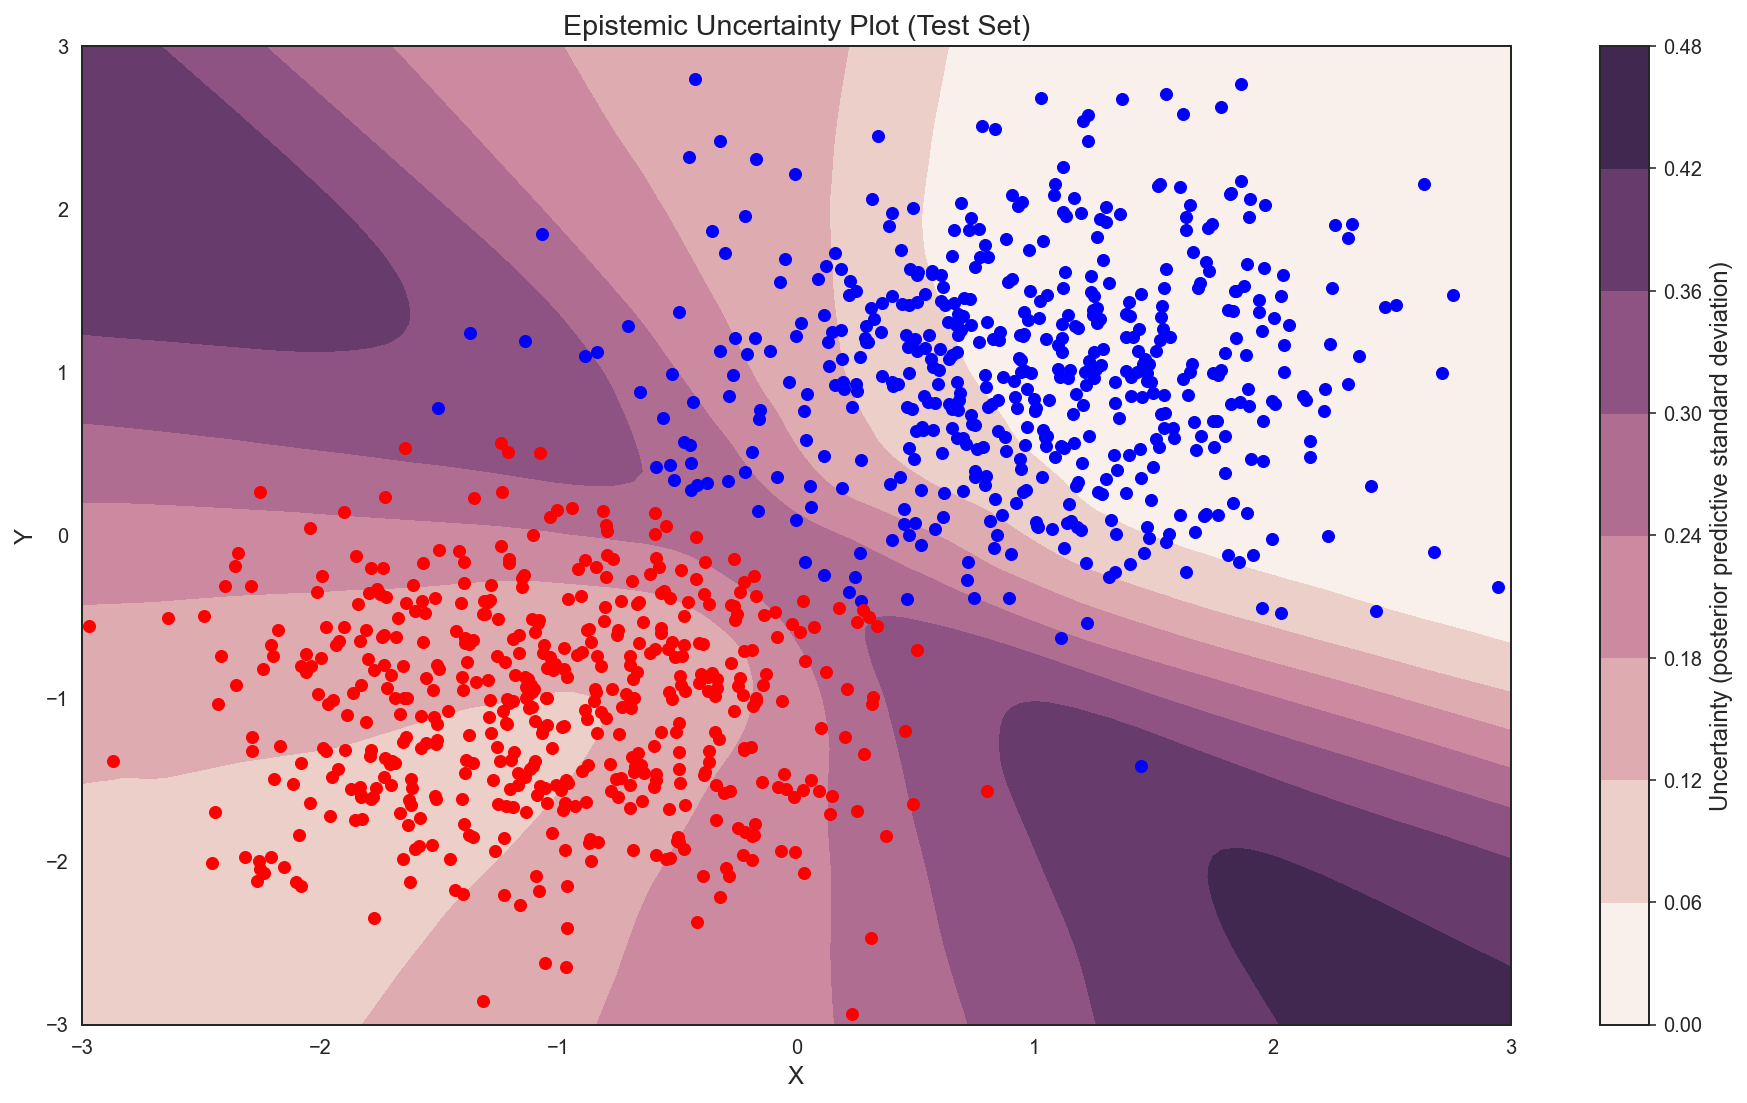

In [97]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.std(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[random_pred_test_labels[:,0]==0, 0], X_test[random_pred_test_labels[:,0]==0, 1], color='b')
ax.scatter(X_test[random_pred_test_labels[:,0]==1, 0], X_test[random_pred_test_labels[:,0]==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Epistemic Uncertainty Plot (Test Set)")
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

### HMC

In [38]:
Y_train_onedim = []
for y in Y_train:
    Y_train_onedim.append(y[0])

Y_train_onedim = np.array(Y_train_onedim)
Y_train_onedim.shape

(1000,)

In [39]:
Y_test_onedim = []
for y in Y_test:
    Y_test_onedim.append(y[0])

Y_test_onedim = np.array(Y_test_onedim)
Y_test_onedim.shape

(1000,)

In [40]:
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)

In [41]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', ann_input)
        ann_output = pm.Data('ann_output', ann_output)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train_onedim)

In [42]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [43]:
with neural_network:
    steps = pm.NUTS()
    #use the specify sampler to sample from the posterior of the model
    trace = pm.sample(5000, step=steps, tune=1000, chains=1)

Sequential sampling (1 chains in 1 job)
NUTS: [w_2_out, w_1_2, w_in_1]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 236 seconds.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [44]:
pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test_onedim}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

In [45]:
pred = ppc["out"].mean(axis=0) > 0.5

In [51]:
print('Test Set Accuracy = {}%'.format((Y_test_onedim == pred).mean() * 100))

Test Set Accuracy = 97.6%


In [47]:
pm.set_data(new_data={'ann_input': grid_2d, 'ann_output': dummy_out}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

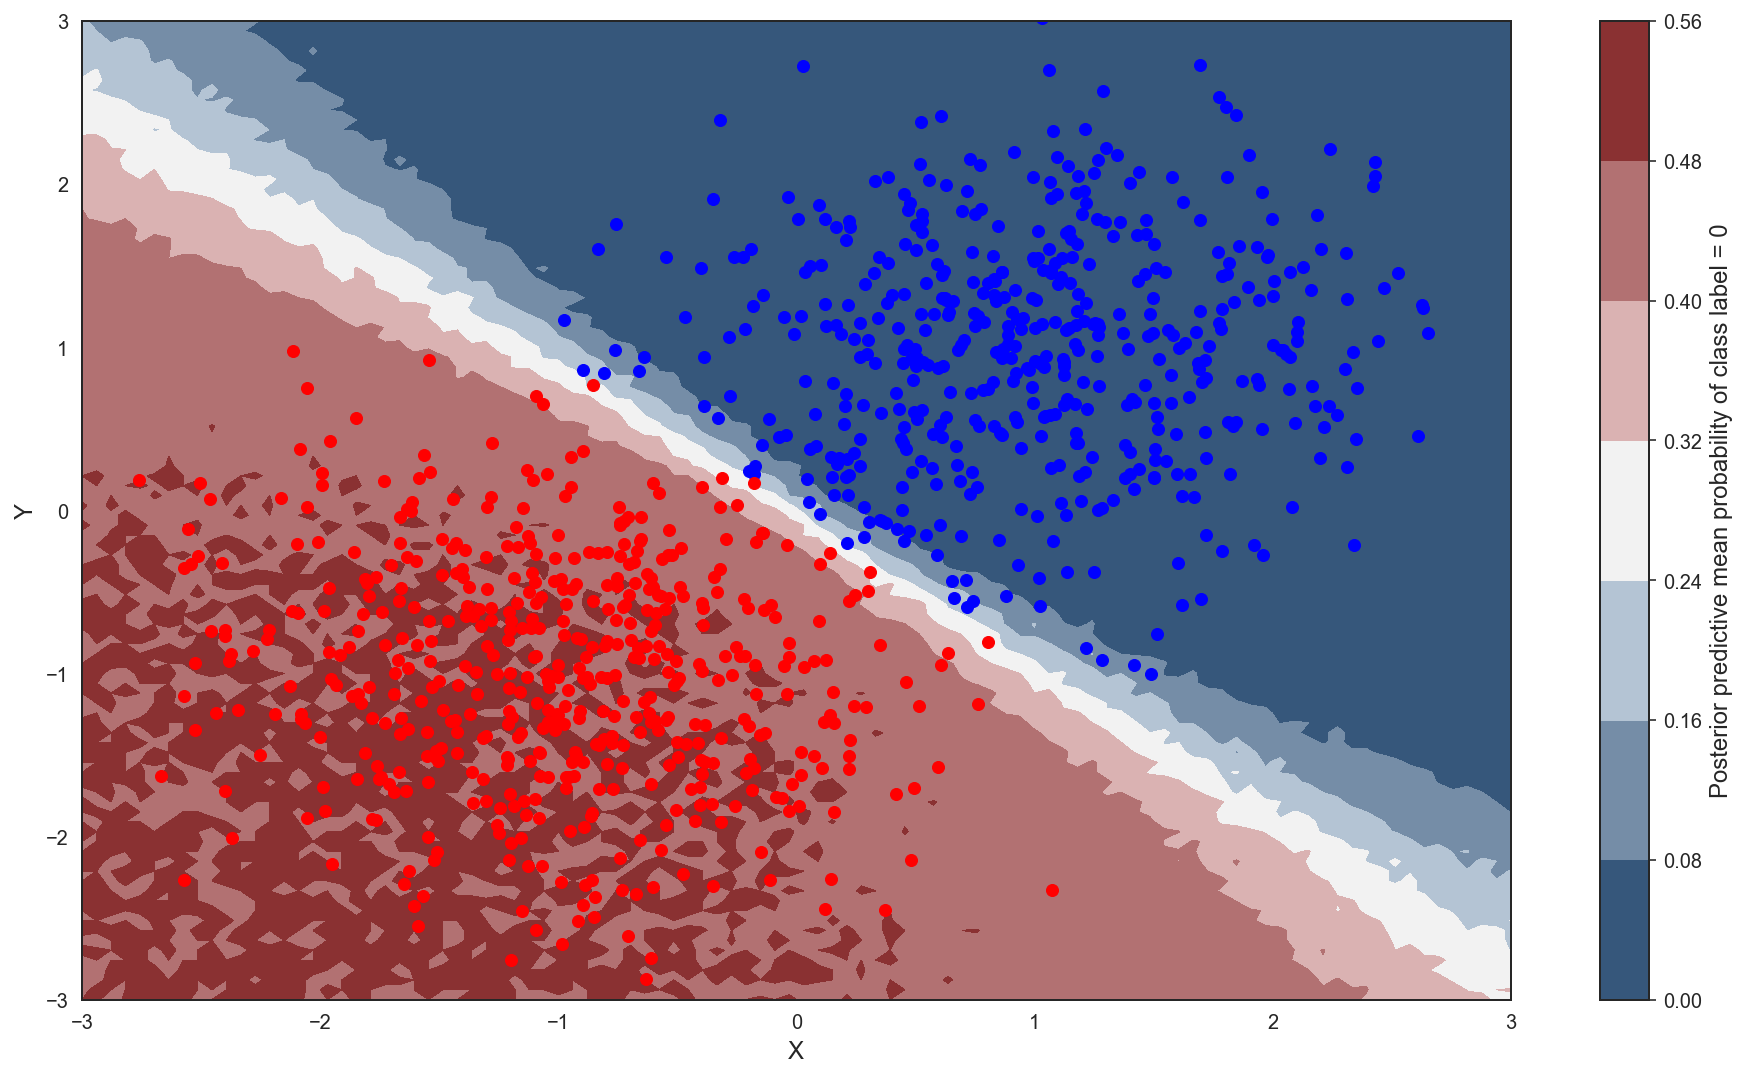

In [48]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc["out"].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1], color='b')
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Posterior predictive mean probabilities - (Test Set)")
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

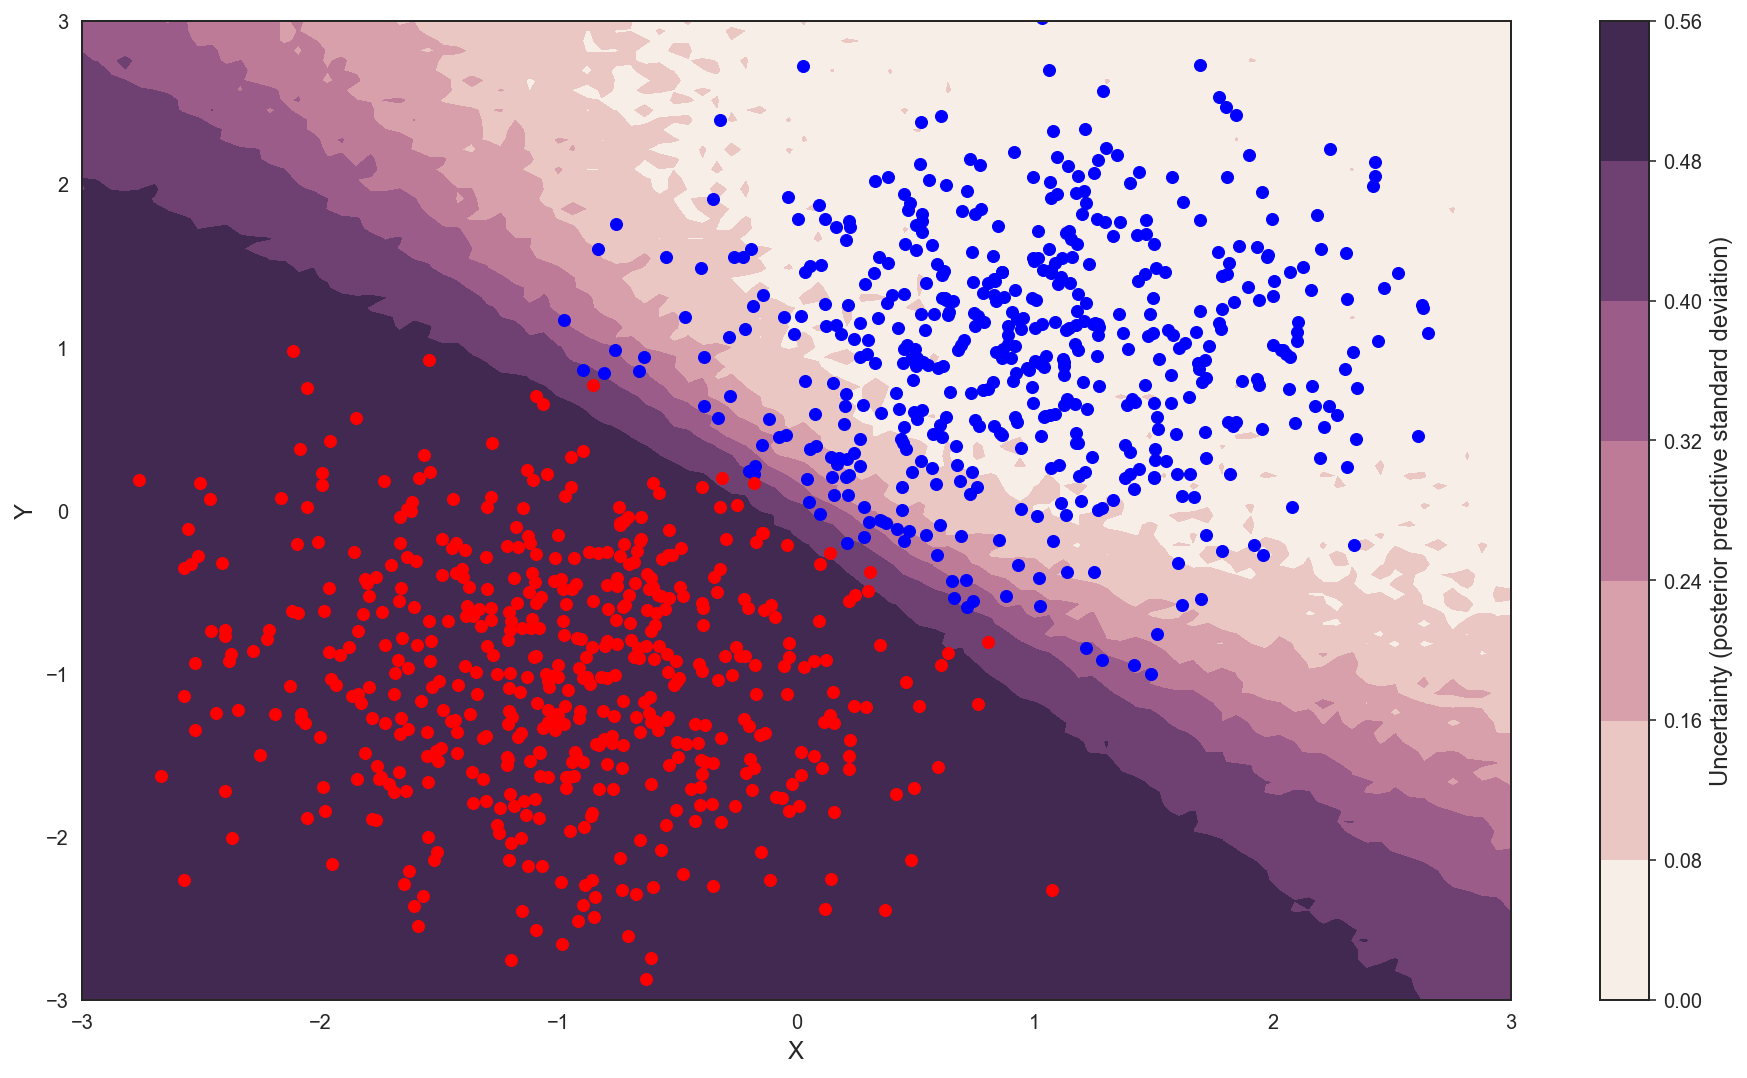

In [49]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc["out"].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1], color='b')
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Epistemic Uncertainty Plot (Test Set)")
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

### ADVI

In [53]:
neural_network = construct_nn(X_train, Y_train_onedim)

In [54]:
with neural_network:
    steps = pm.ADVI()
    #use the specify sampler to sample from the posterior of the model
    approx = pm.fit(n=30000, method=steps)

Finished [100%]: Average Loss = 95.061


In [55]:
# create symbolic input
x_sym = T.matrix('X_test')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n_sym = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x_sym.tag.test_value = np.empty_like(X_test)
n_sym.tag.test_value = X_test.shape[1]
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n_sym,
                                   more_replacements={neural_network['ann_input']: x_sym})
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x_sym, n_sym], _sample_proba)
pred = (sample_proba(X_test, 500).mean(0) > 0.5) * 1
print('Test Set Accuracy = {}%'.format((Y_test_onedim == pred).mean() * 100))

Test Set Accuracy = 97.6%


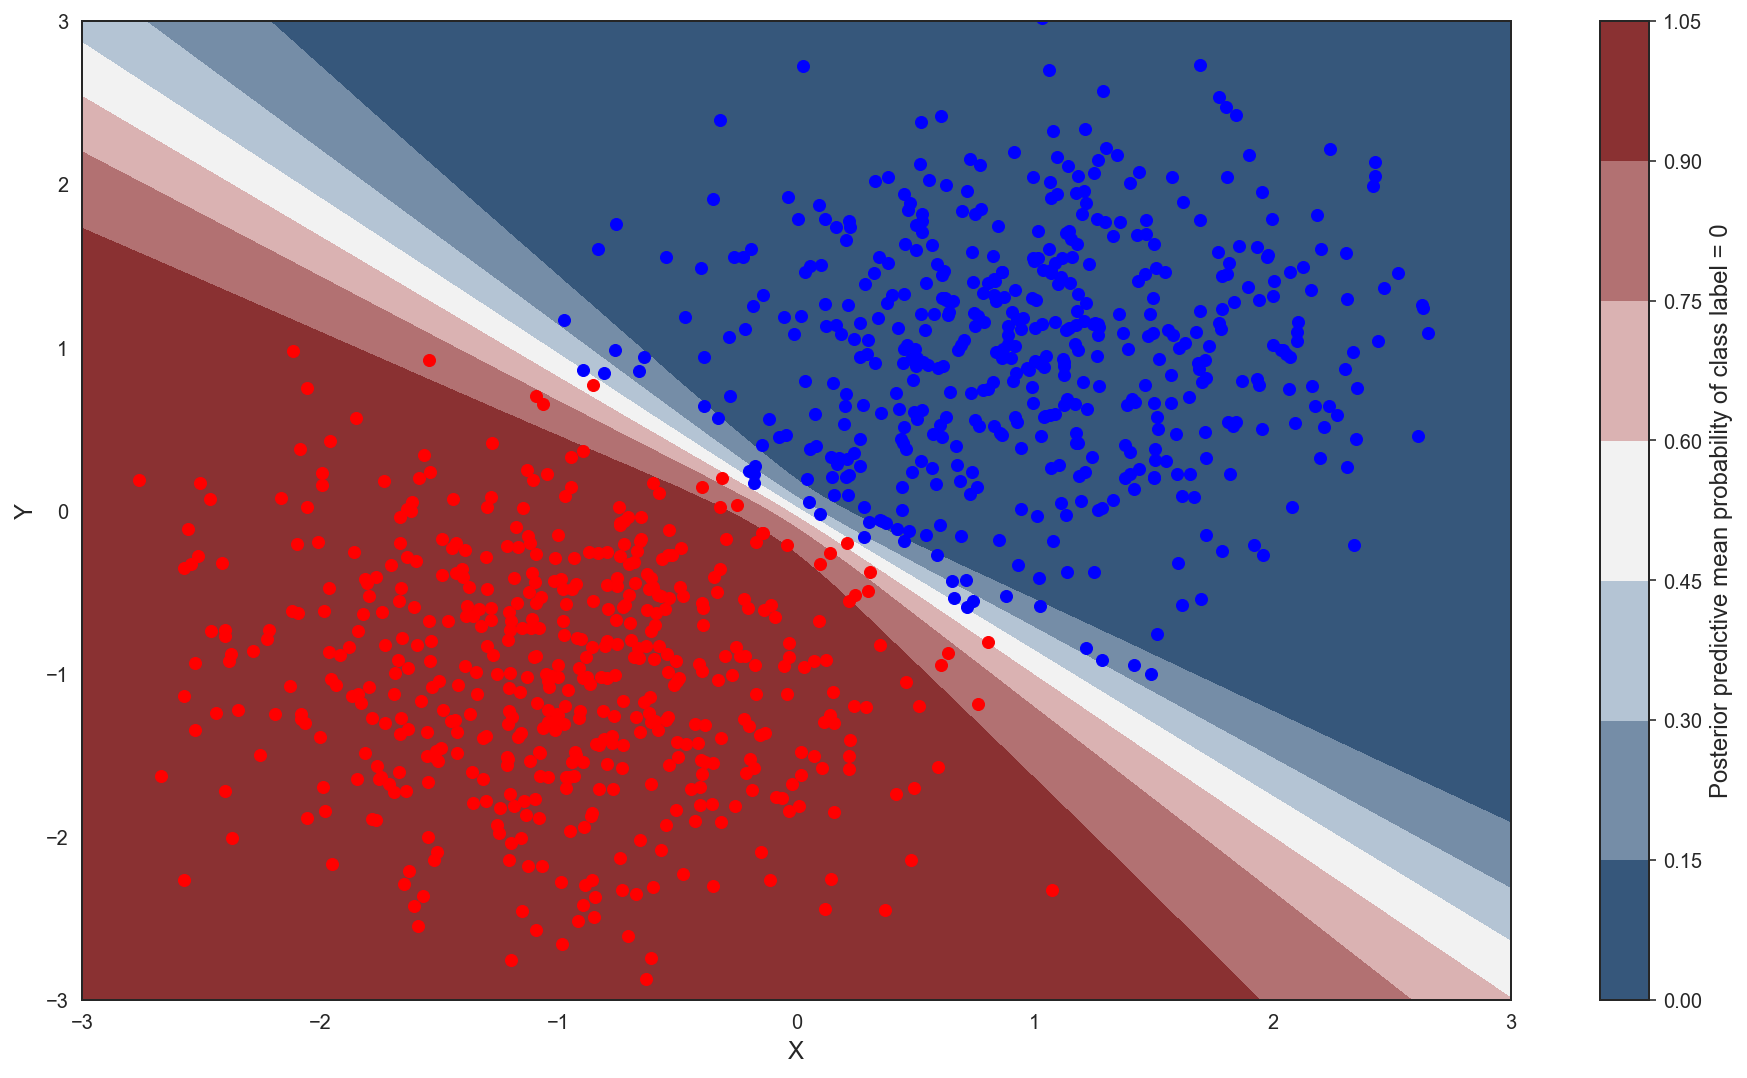

In [56]:
# populate grid with average predictions
ppc = sample_proba(grid_2d ,500)
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1], color='b')
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Posterior predictive mean probabilities - (Test Set)")
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

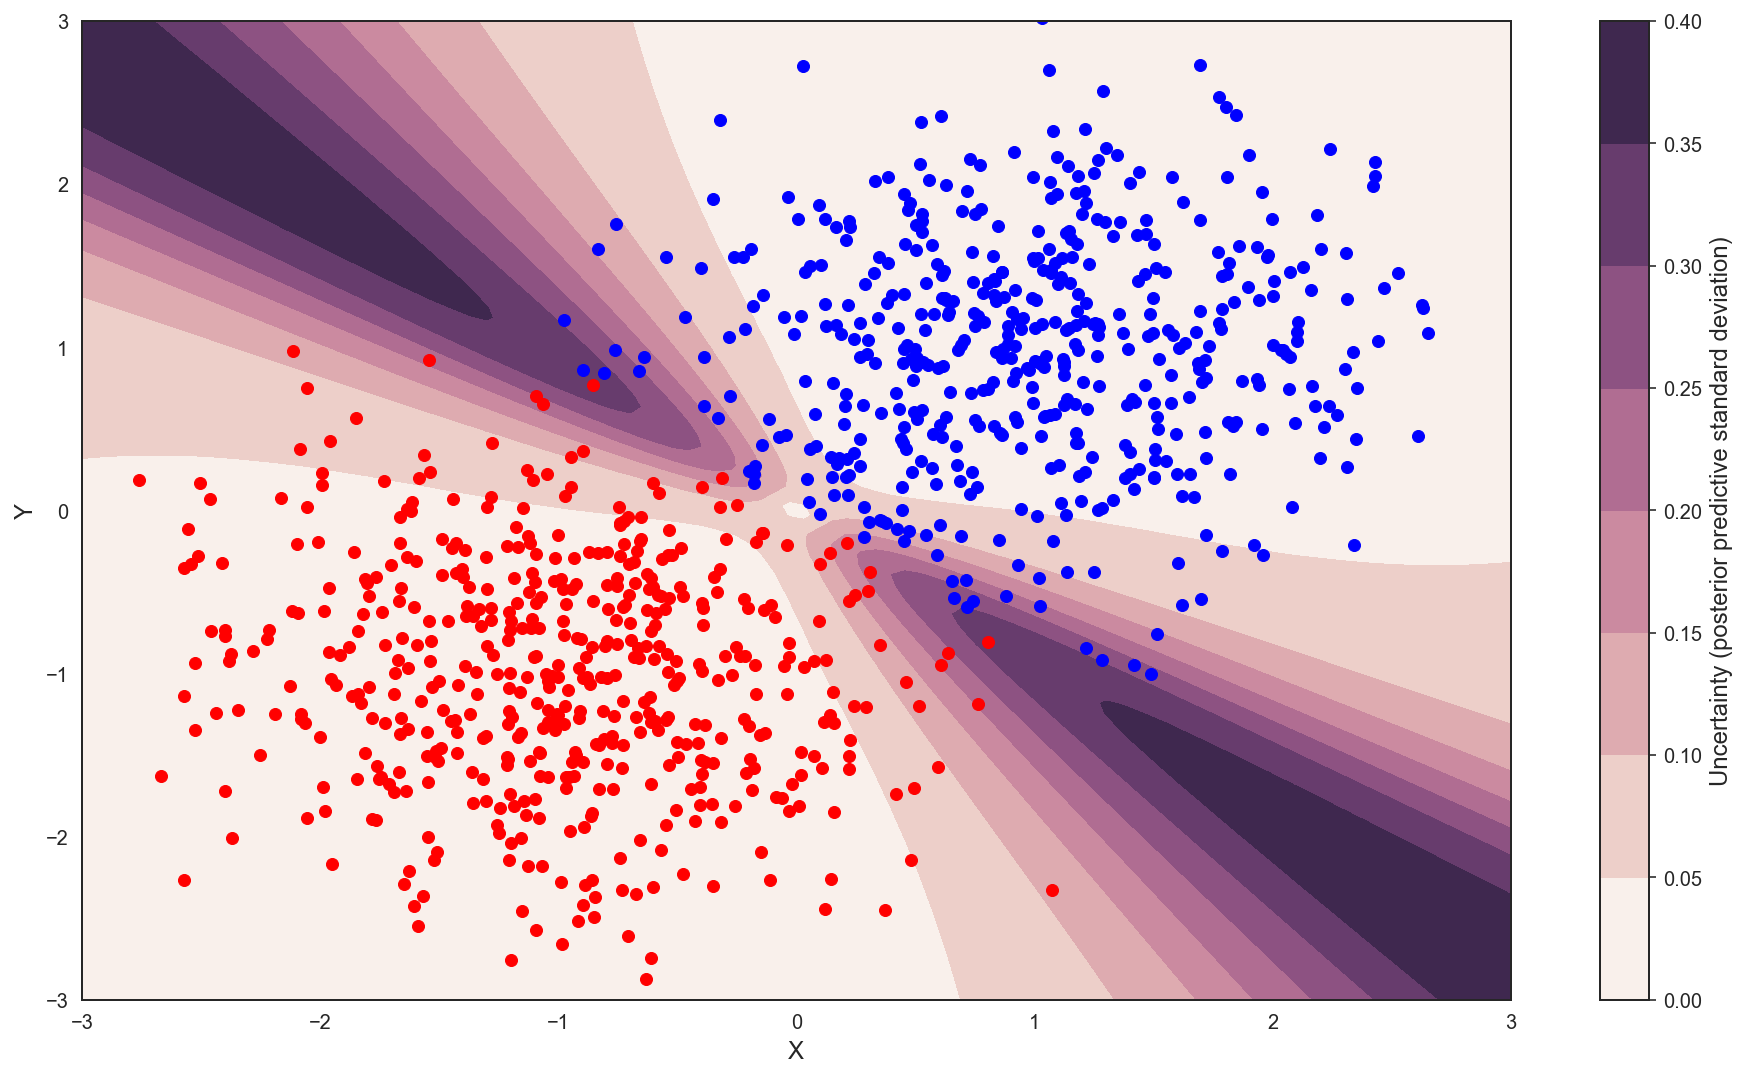

In [57]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1], color='b')
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("Epistemic Uncertainty Plot (Test Set)")
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');